In [1]:
import networkx as nx
import matplotlib.pyplot as plt

def pretty_print(graph, title = "Graph Visualization",weighted = False, directed = False, heuristic = None):
    g = nx.DiGraph() if directed else nx.Graph()
    for u in graph:
        label = u
        if heuristic:
            label += "("+str(heuristic[u])+")"
        g.add_node(u, label = label)
        for v in graph[u]:
            g.add_edge(u, v, weight = graph[u][v])
    pos = nx.circular_layout(g)
    nx.draw(g, pos, 
            node_size = 1200, node_color = 'lightgreen',
            width = 1.5, edge_color = 'red',
            edgecolors = 'black', linewidths = 1.5,
            margins = 0.25, clip_on = False)
    nx.draw_networkx_labels(g, pos, labels = nx.get_node_attributes(g, 'label'),
                            font_size = 12, font_family = 'cursive')
    if weighted:
        nx.draw_networkx_edge_labels(g, pos, 
                                     edge_labels = nx.get_edge_attributes(g, 'weight'),
                                     font_size = 8, font_family = 'cursive')
    plt.suptitle(title)
    plt.axis('off')
    plt.show()
    plt.clf()

In [2]:
def display(graph):
    g = nx.DiGraph()
    for u in graph:
        g.add_node(u)
        for v in graph[u]:
            g.add_edge(u, v, weight = graph[u][v])
    pos = nx.circular_layout(g)
    nx.draw(g, pos, with_labels = True)
    nx.draw_networkx_edge_labels(g, pos, edge_labels = nx.get_edge_attributes(g, 'weight'))
    plt.show()
    plt.clf()

In [3]:
def get_input(heuristic = False, weighted = False, bound = False, directed = False):
    rtn = []
    graph = {}
    rtn.append(graph)
    if heuristic:
        h = {}
        for _ in range(int(input("Enter no of nodes: "))):
            x, hval = input("Enter node and heuristic value: ").split()
            h[x] = int(hval)
        rtn.append(h)
    for _ in range(int(input("Enter no of edges: "))):
        if weighted:
            u, v, w = input("Enter (node, adj, weight): ").split()
        else:
            u, v = input("Enter (node, adj): ").split()
            w = 0
        graph[u] = graph.get(u,{})
        graph[u][v] = int(w)
        if not directed:
            graph[v] = graph.get(v,{})
            graph[v][u] = int(w)
    source, goal = input("Enter source and goal: ").split()
    if bound:
        b = int(input("Enter memory bound: "))
        rtn.append(b)
    rtn.extend([source, goal])
    return rtn

In [4]:
def print_path(node, parent):
    if node != None:
        return print_path(parent[node], parent) + [node]
    return []

In [5]:
def BFS(graph, start, goal):
    queue = [start]
    visited = []
    parent = {start : None}
    while queue:
        node = queue.pop(0)#First element
        visited.append(node)
        if node == goal:
            print("Result(BFS):",print_path(node, parent))
            return True
        for adj in graph[node]:
            if adj not in visited and adj not in queue:
                queue.append(adj)
                parent[adj] = node
    return False

In [6]:
def DFS(graph, start, goal):
    stack = [start]
    visited = []
    parent = {start : None}
    while stack:
        node = stack.pop()#last element
        visited.append(node)
        if node == goal:
            print("Result(DFS):",print_path(node, parent))
            return True
        for adj in graph[node]:
            if adj not in visited and adj not in stack:
                stack.append(adj)
                parent[adj] = node
    return False

In [7]:
def UCS(graph, start, goal):
    queue = [start]
    visited = []
    parent = {start : None}
    cost = {start : 0}
    while queue:
        queue.sort(key = lambda x : cost[x])
        node = queue.pop(0)
        visited.append(node)
        if node == goal:
            print("Result(UCS):",print_path(node, parent),"Path cost =",cost[node])
            return True
        for adj in graph[node]:
            if adj not in visited:
                new_cost = cost[node] + graph[node][adj]
                if adj not in queue:
                    queue.append(adj)
                elif new_cost > cost[adj]:
                    continue
                cost[adj] = new_cost
                parent[adj] = node
    return False

In [8]:
def DLS(graph, start, goal, limit):
    result = recursive_dls(graph, start, goal, limit, [start])
    print("Result(DLS):",result)


def recursive_dls(graph, node, goal, limit, visited):
    if node == goal:
        return [node]
    elif limit == 0:
        return 'cutoff'
    else:
        status = 'failure'
        for adj in graph[node]:
            if adj not in visited:
                visited.append(adj)
                result = recursive_dls(graph, adj, goal, limit - 1, visited)
                if result == 'cutoff':
                    status = 'cutoff'
                    visited.remove(adj)
                elif result != 'failure':
                    return [node] + result
        return status

In [9]:
def IDS(graph, start, goal):
    depth = 0
    while True:
        result = recursive_dls(graph, start, goal, depth, [start])
        print("Result(IDS/IDDFS):",result,"at depth limit =",depth)
        if result != 'cutoff':
            return
        depth += 1

In [10]:
def AStar(graph, start, goal, h):
    queue = [start]
    visited = []
    parent = {start : None}
    g = {start : 0}
    f = {start : h[start]}
    while queue:
        queue.sort(key = lambda x : f[x])
        node = queue.pop(0)
        visited.append(node)
        if node == goal:
            print("Result(A*):",print_path(node, parent),"Path cost =",g[node])
            return True
        for adj in graph[node]:
            if adj not in visited:
                gcost = g[node] + graph[node][adj]
                fcost = gcost + h[adj]
                if adj not in queue:
                    queue.append(adj)
                elif fcost > f[adj]:
                    continue
                g[adj] = gcost
                f[adj] = fcost
                parent[adj] = node
    return False

In [11]:
def IDAStar(graph, start, goal, h):
    def dfs(graph, parent, node, goal, g, h, th):
        f = g + h[node]
        if f > th:
            return None, f
        if node == goal:
            return node, f
        min_th = inf
        for adj in graph[node]:
            result, temp_th = dfs(graph, parent, adj, goal, g + graph[node][adj], h, th)
            if result is not None:
                parent[adj] = node
                return result, temp_th
            elif temp_th < min_th:
                min_th = temp_th
        return None, min_th
    
    inf = 9999999
    parent = {start : None}    
    th = h[start]
    while True:
        result, new_th = dfs(graph, parent, start, goal, 0, h, th)
        if result is not None:
            result = print_path(result, parent)
            cost = sum([graph[n1][n2] for n1, n2 in zip(result,result[1:])])
            print("Result(IDA*):",result,"Path cost =",cost)
            return
        elif new_th == inf:
            print("Result(IDA*): failure")
            return
        th = new_th

In [12]:
def SMAStar(graph, start, goal, h, bound):
    queue = [start]
    visited = []
    parent = {start : None}
    g = {start : 0}
    f = {start : h[start]}
    backup = {}
    while queue:
        queue.sort(key = lambda x : f[x])
        node = queue.pop(0)
        visited.append(node)
        if node == goal:
            print("Result(SMA*):",print_path(node, parent),"Path cost =",g[node])
            return True
        successors = []
        for adj in graph[node]:
            if adj in visited:
                continue
            gcost = g[node] + graph[node][adj]
            fcost = gcost + h[adj]
            if adj in queue:
                if fcost >= f[adj]:
                    continue
            elif len(queue) < bound:
                    queue.append(adj)
            else:
                worst = max(queue, key = lambda x : f[x])
                if fcost < f[worst]:
                    backup[worst] = f[worst]
                    queue.remove(worst)
                    queue.append(adj)
                else:
                    continue
            g[adj] = gcost
            f[adj] = fcost
            parent[adj] = node
            successors.append(adj)
        if not successors and node in backup:
            f[node] = backup[node]
        elif not successors:
            f[node] = float('inf')
    return False

In [13]:
def SMAStar(graph, start, goal, h, bound):
    queue = [start]
    visited = []
    parent = {start : None}
    g = {start : 0}
    f = {start : h[start]}
    backup = {}
    while queue:
        queue.sort(key = lambda x : f[x])
        node = queue.pop(0)
        visited.append(node)
        if node == goal:
            print("Result(SMA*):",print_path(node, parent),"Path cost =",g[node])
            return True
        successors = []
        for adj in graph[node]:
            if adj in visited:
                continue
            gcost = g[node] + graph[node][adj]
            fcost = gcost + h[adj]
            if adj in queue:
                if fcost >= f[adj]:
                    continue
            elif len(queue) < bound:
                    queue.append(adj)
            else:
                worst = max(queue, key = lambda x : f[x])
                if fcost < f[worst]:
                    backup[worst] = f[worst]
                    queue.remove(worst)
                    queue.append(adj)
                else:
                    continue
            g[adj] = gcost
            f[adj] = fcost
            parent[adj] = node
            successors.append(adj)
        if not successors and node in backup:
            f[node] = backup[node]
        elif not successors:
            f[node] = float('inf')
    return False

In [14]:
from random import randint as rint
def genetic(gen, pop):
    def show(b):
        board = [ ['_'] * n for _ in range(n)]
        for i in range(n):
            board[int(b[i])-1][i] = 'Q'
        print(f" {' '.join(['_']*n)}")
        for i in board:
            print(f"|{'|'.join(i)}|")
    def mutate(b1, b2):
        b1, b2 = list(b1), list(b2)
        x, y = rint(0,n-1), rint(0,n-1)
        b1[x], b2[x] = b2[x], b1[x]
        b1[y] = str(int(y) + 1)
        return (''.join(b1),''.join(b2))
    def crossover(b1, b2):
        b1, b2 = list(b1), list(b2)
        x = rint(1,n-1)
        b1[0:x], b2[0:x] = b2[0:x], b1[0:x]
        return (''.join(b1), ''.join(b2))
    def fitness(b):
        b = list(b)
        attacks = 0
        for i in range(n):
            for j in range(i+1, n):
                if b[i] == b[j] or abs(int(b[i]) - int(b[j])) == j - i:
                    attacks += 1
        return attacks
    n = len(pop[0])
    i = 0
    pq = []
    pq.append((fitness(pop[0]),pop[0]))
    pq.append((fitness(pop[1]),pop[1]))
    for i in range(gen+1):
        f1, b1 = pq.pop(0)
        f2, b2 = pq.pop(0)
        pq.clear()
        if f1 == 0:
            print("Goal State:",b1,"Generation:",i+1)
            show(b1)
            return
        elif f2 == 0:
            print("Goal State:",b2,"Generation:",i+1)
            show(b2)
            return
        x1, x2 = crossover(b1, b2)
        x3, x4 = crossover(b2, b1)
        new_pop = [(x1, x2), (x3, x4), mutate(x1, x2), mutate(x2, x1)]
        for child in new_pop:
            pq.append((fitness(child[0]), child[0]))
            pq.append((fitness(child[1]), child[1]))
        pq.append((f1, b1))
        pq.append((f2, b2))
        pq.sort(key = lambda x : x[0])
    print("Most Evolved State:",pq[0][1],"Generation:",i,"Attacks:",pq[0][0])
    show(pq[0][1])

In [15]:
import math
import random
def simulated_annealing(initsol, inittemp, alpha, iters):
    def fcost(sol):
        return sum([i**2 for i in sol])
    def successors(sol, step = 1.0):
        succ = [x + random.uniform(-step,step) for x in sol]
        return succ
    currsol = initsol
    cost = fcost(currsol)
    sol = currsol
    mincost = cost
    temp = inittemp
    for iteration in range(iters):
        neighbor = successors(currsol)
        ncost = fcost(neighbor)
        costdiff = ncost - cost
        if costdiff < 0 or random.random() < math.exp(-costdiff/temp):
            currsol = neighbor
            cost = ncost
            if cost < mincost:
                sol = currsol
                mincost = cost
        temp *= alpha
    return sol, mincost

In [16]:
import math 
import random
def sudoku_simulated_annealing(board, initial_temp = 1.0, cooling_rate = 0.99, min_temp = 0.001):
    def display(board):
        for row in board:
            print(' '.join(str(num) if num != 0 else '.' for num in row))
        print()
    def fill(board):
        for i in range(9):
            choices = list(set(range(1,10)) - set(board[i]) - {0})
            random.shuffle(choices)
            for j in range(9):
                if board[i][j] == 0:
                    board[i][j] = choices.pop()
    def cost(board):
        conflicts = 0
        for n in range(9):
            row = board[n]
            col = [x[n] for x in board]
            conflicts += len(row) - len(set(row))
            conflicts += len(col) - len(set(col))
        for l in [0,3,6]:
            for k in [0,3,6]:
                block = []
                for i in range(0+l,3+l):
                    for j in range(0+k,3+k):
                        block.append(board[i][j])
                conflicts += 9 - len(set(block))
        return conflicts
    def next(board, fixed):
        neighbor = [[x for x in row] for row in board]
        i = random.randint(0,8)
        cols = [j for j in range(9) if (i,j) not in fixed]
        if len(cols) >= 2:
            j1, j2 = random.sample(cols, 2)
            neighbor[i][j1], neighbor[i][j2] = neighbor[i][j2], neighbor[i][j1]
        return neighbor
    fixed = [(x,y) for x in range(9) for y in range(9) if board[x][y] != 0]
    fill(board)
    current = best = board
    temp = initial_temp
    while temp > min_temp:
        neighbor = next(current,fixed)
        delta = cost(neighbor) - cost(current)
        if delta < 0:
            current = neighbor
            if cost(neighbor) < cost(best):
                best = neighbor
        else:
            if random.random() < math.exp(-delta/temp):
                current = neighbor
        temp *= cooling_rate
    print(f"Sudoku ({'Best Possible State | Attacks = '+str(cost(best)) if cost(best) else 'Solved'})") 
    display(best)

In [17]:
import networkx as nx
import matplotlib.pyplot as plt
def show_tree(graph):
    graph = {node : [adj for adj in graph[node]] for node in graph}
    terminal_nodes = set()
    for node in graph:
        for i in range(len(graph[node])):
            x = str(graph[node][i])
            if x.isdigit():
                while x in terminal_nodes:
                    x+=" "
                graph[node][i] = x
                terminal_nodes.add(x)
    g = nx.DiGraph(graph)
    levels = nx.single_source_shortest_path_length(g, next(iter(g.nodes)))
    layers = {}
    for node, level in levels.items():
        layers[level] = layers.get(level, []) + [node]
    pos = {}
    for level, nodes in layers.items():
        x_offset = (len(nodes) - 1)/2
        for i, node in enumerate(nodes):
            x = i - x_offset
            y = -level
            pos[node] = (x,y)
    plt.figure(figsize = (8,4))
    nx.draw(g, pos, with_labels = True, 
            node_size = 600, node_color = 'lightgreen',
            font_size = 12, font_family = 'cursive',
            arrows = False, width = 1.5, edge_color = 'red',
            edgecolors = 'black', linewidths = 1.5,
            margins = 0.1, clip_on = False)
    plt.suptitle("Alpha Beta Pruning")
    plt.show()
    plt.clf()
MIN = -float('inf')
MAX = float('inf')
def alphabeta(node, graph, ismax, pruned = [], alpha = MIN, beta = MAX, path = {}):
    if str(node).isdigit():
        return int(node), pruned, path
    option = MIN if ismax else MAX
    for child in graph[node]:
        val, _, _ = alphabeta(child, graph, not ismax, pruned, alpha, beta, path)
        if ismax:
            option = max(option, val)
            alpha = max(option, alpha)
            path[node] = alpha
        else:
            option = min(option, val)
            beta = min(option, beta)
            path[node] = beta
        if alpha >= beta:
            i = graph[node].index(child)+1
            pruned += [f"{node}-{adj}" for adj in graph[node][i:]]
            break
    return option, pruned, path
def show_path(node, graph, path, value):
    for adj in graph[node]:
        if str(adj).isdigit():
            return [node,str(value)]
        if path[adj] == value:
            return [node] + show_path(adj, graph, path, value)

In [18]:
import networkx as nx
import matplotlib.pyplot as plt

def backtrack_map(graph, colors):
    def rec_backtrack(assign, graph, colors):
        if -1 not in assign.values():
            return assign
        node = [x for x in assign if assign[x] == -1][0]
        for color in colors:
            if all(assign[adj] != color for adj in graph[node]):
                assign[node] = color
                result = rec_backtrack(assign, graph, colors)
                if result:
                    return result
                assign[node] = -1
        return None

    assign = {node : -1 for node in graph}
    return rec_backtrack(assign, graph, colors)
def display_map(graph, colors = None):
    g = nx.DiGraph(graph)
    #nx.draw_circular(g, with_labels = True, node_color = colors)
    nx.draw_circular(g, with_labels = True,
                    node_size = 600, node_color = colors,
                    font_size = 12, font_family = 'cursive',
                    arrows = False, width = 1.25,
                    edgecolors = 'black', linewidths = 1.5,
                    margins = 0.375, clip_on = False)
    plt.suptitle("Map Coloring(Constraint Satisfaction Problem)")
    plt.show()
    plt.clf()

In [19]:
import networkx as nx
import matplotlib.pyplot as plt

def backtrack_house(houses, locs):
    def check(assign, loc):
        #constraints given in the question
        #change it accordinly
    
        a = assign['A']
        b = assign['B']
        c = assign['C']
        d = assign['D']
        
        #1. C lives in a house higher than D
        if c != -1 and d != -1 and c < d:return False
    
        #2. D lives next to A in Lower number House
        if d != -1 and a != -1 and (a - d) != 1:return False
    
        #3. There is at least one house between D and B    
        if d != -1 and b != -1 and abs(d - b) == 1:return False
    
        #4. C doesn't live in house number 3
        if c != -1 and c == 3:return False
    
        #5. B doesn't live in house number 1
        if b != -1 and b == 1:return False
            
        if loc in assign.values():
            return False
        return True
    def rec_backtrack(assign, locs):
        if check(assign, -1):
            return assign
        choices = [x for x in assign if assign[x] == -1]
        house = choices[0] if choices else None
        for loc in locs:
            if check(assign, loc):
                assign[house] = loc
                res = rec_backtrack(assign, locs)
                if res:
                    return res
                assign[house] = -1
        return None

    assign = {house : -1 for house in houses}    
    return rec_backtrack(assign, locs)
def display_house(result):
    g = nx.Graph()
    nodes = list(result.keys())
    nodes.sort(key = lambda x : result[x])
    nodes = [f"{node}({result[node]})" for node in nodes]
    for u, v in zip(nodes, nodes[1:]):
        g.add_edge(u, v)
    pos = {node : (0, i) for i, node in enumerate(nodes)}
    nx.draw(g, pos, with_labels = True,
            width = 1.5, edge_color = 'red',
            node_size = 800, node_color = 'lightgreen',
            font_size = 12, font_family = 'cursive',
            edgecolors = 'black', linewidths = 1.5,
            margins = 0.2, clip_on = False)
    plt.suptitle("House Allocation(Constraint Satisfaction Problem)")
    plt.show()
    plt.clf()

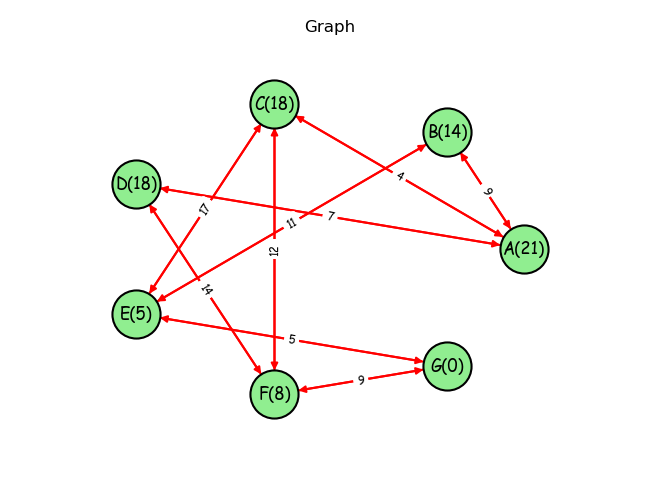

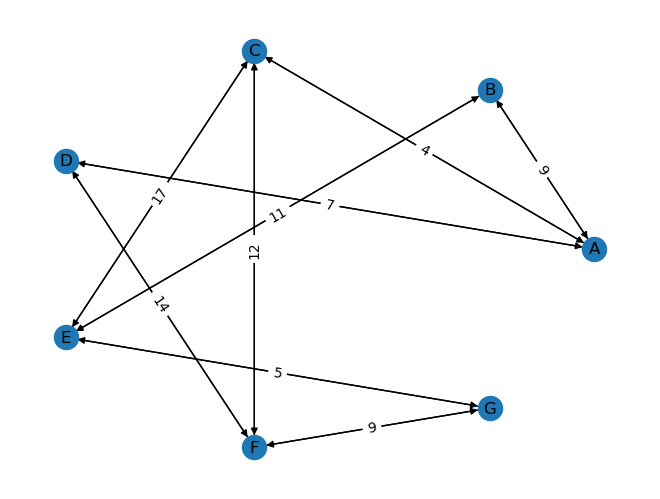

Result(BFS): ['A', 'C', 'F']
Result(DFS): ['A', 'D', 'F']
Result(UCS): ['A', 'B', 'E', 'G'] Path cost = 25
Result(DLS): ['A', 'B', 'E', 'G']
Result(IDS/IDDFS): cutoff at depth limit = 0
Result(IDS/IDDFS): cutoff at depth limit = 1
Result(IDS/IDDFS): cutoff at depth limit = 2
Result(IDS/IDDFS): ['A', 'B', 'E', 'G'] at depth limit = 3
Result(A*): ['A', 'B', 'E', 'G'] Path cost = 25
Result(IDA*): ['A', 'B', 'E', 'G'] Path cost = 25
Result(SMA*): ['A', 'C', 'F', 'G'] Path cost = 25
Genetic Algorithm Example 1(5 Queen): 
Most Evolved State: 14152 Generation: 1000 Attacks: 1
 _ _ _ _ _
|Q|_|Q|_|_|
|_|_|_|_|Q|
|_|_|_|_|_|
|_|Q|_|_|_|
|_|_|_|Q|_|

Genetic Algorithm Example 2(8 Queen): 
Goal State: 57142863 Generation: 2
 _ _ _ _ _ _ _ _
|_|_|Q|_|_|_|_|_|
|_|_|_|_|Q|_|_|_|
|_|_|_|_|_|_|_|Q|
|_|_|_|Q|_|_|_|_|
|Q|_|_|_|_|_|_|_|
|_|_|_|_|_|_|Q|_|
|_|Q|_|_|_|_|_|_|
|_|_|_|_|_|Q|_|_|

Simulated Annealing Best Solution: [234.2396122361404, 306.6568873850056]
Simulated Annealing Best Cost: 148906.6425

<Figure size 640x480 with 0 Axes>

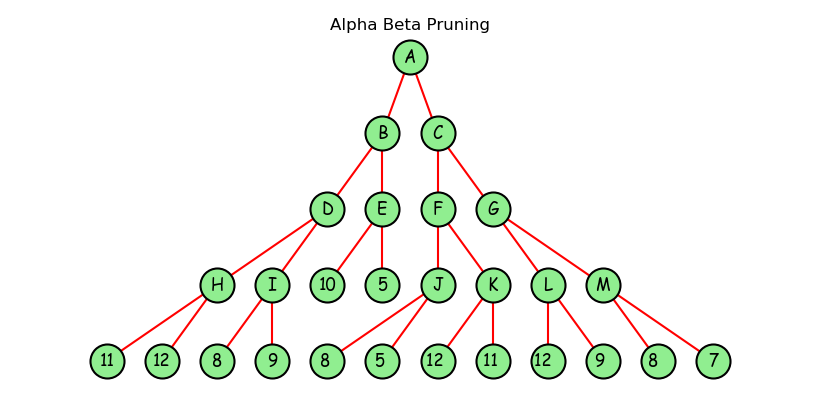

{'A': ['B', 'C'], 'B': ['D', 'E'], 'C': ['F', 'G'], 'D': ['H', 'I'], 'E': [10, 5], 'F': ['J', 'K'], 'G': ['L', 'M'], 'H': [11, 12], 'I': [8, 9], 'J': [8, 5], 'K': [12, 11], 'L': [12, 9], 'M': [8, 7]}
Alpha Beta Pruning(Maximize): 10  Pruned Branches: I-9, J-5, M-7  Path: A->B->E->10
Alpha Beta Pruning(Minimize): 8  Pruned Branches: I-9, J-5, M-7, K-11, L-9  Path: A->C->F->J->8

Constraint Satisfaction Problem(Map Coloring)


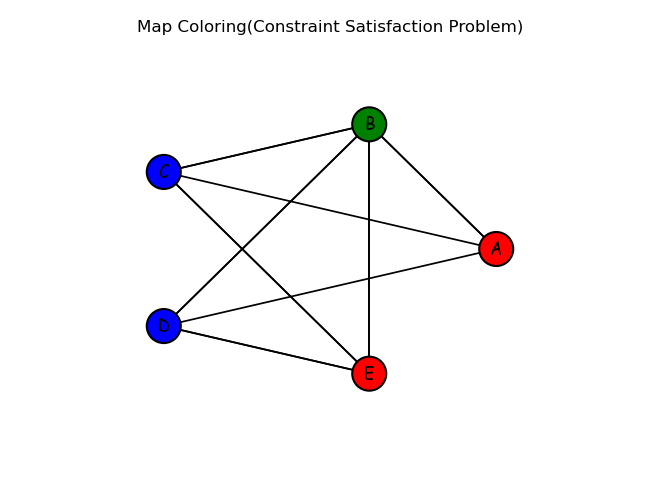

Node: A  Color: red
Node: B  Color: green
Node: C  Color: blue
Node: D  Color: blue
Node: E  Color: red

Constraint Satisfaction Problem(House Allocation)


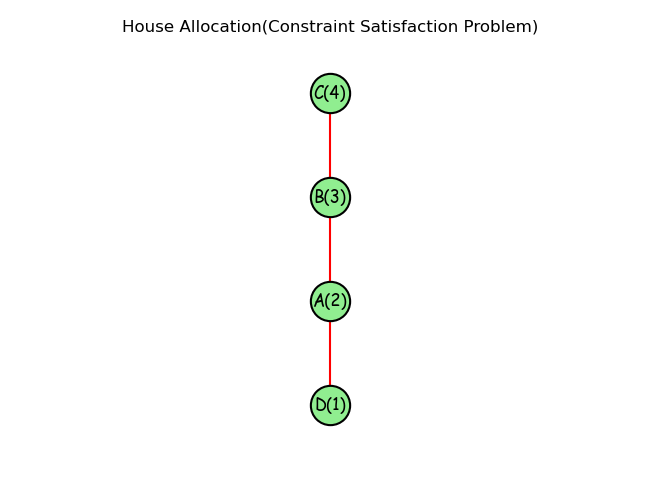

House: A  Location: 2
House: B  Location: 3
House: C  Location: 4
House: D  Location: 1


<Figure size 640x480 with 0 Axes>

In [20]:
def main():
    graph = {"A" : {"B":9,"C":4,"D":7},
             "B" : {"A":9,"E":11},
             "C" : {"A":4,"E":17,"F":12},
             "D" : {"A":7,"F":14},
             "E" : {"B":11,"G":5,"C":17},
             "F" : {"D":14,"C":12,"G":9},
             "G" : {"E":5,"F":9}}
    heuristic = {"A":21,"B":14,"C":18,"D":18,"E":5,"F":8,"G":0}
    pretty_print(graph, title = "Graph", weighted = True, directed = True, heuristic = heuristic)
    display(graph)
    
    BFS(graph, "A", "F")
    
    DFS(graph, "A", "F")
    
    UCS(graph, "A", "G")
    
    DLS(graph, "A", "G", 3)
    
    IDS(graph, "A", "G")
    
    AStar(graph, "A", "G", heuristic)
    
    IDAStar(graph, "A", "G", heuristic)
    
    #graph, heuristic, bound, source, goal = get_input(heuristic = True,weighted = True,bound = True)
    SMAStar(graph, "A", "G", heuristic, bound = 3)
    
    print("Genetic Algorithm Example 1(5 Queen): ")
    genetic(1000, ["32152","24345"])
    print()
    print("Genetic Algorithm Example 2(8 Queen): ")
    genetic(1000, ["57142860","56782463"])
    print()
    
    initsol = [300.0, 400.0]
    inittemp = 1000.0
    alpha = 0.95
    iters = 500
    bestsol, cost = simulated_annealing(initsol, inittemp, alpha, iters)
    print("Simulated Annealing Best Solution:",bestsol)
    print("Simulated Annealing Best Cost:",cost)
    print()
    
    board =[[5, 3, 0, 0, 7, 0, 0, 0, 0],
            [6, 0, 0, 1, 9, 5, 0, 0, 0],
            [0, 9, 8, 0, 0, 0, 0, 6, 0],
            [8, 0, 0, 0, 6, 0, 0, 0, 3],
            [4, 0, 0, 8, 0, 3, 0, 0, 1],
            [7, 0, 0, 0, 2, 0, 0, 0, 6],
            [0, 6, 0, 0, 0, 0, 2, 8, 0],
            [0, 0, 0, 4, 1, 9, 0, 0, 5],
            [0, 0, 0, 0, 8, 0, 0, 7, 9]]
    sudoku_simulated_annealing(board)
    
    graph = {
        'A' : ['B', 'C'],
        'B' : ['D', 'E'],
        'C' : ['F', 'G'],
        'D' : ['H', 'I'],
        'E' : [10, 5],
        'F' : ['J', 'K'],
        'G' : ['L', 'M'],
        'H' : [11, 12],
        'I' : [8, 9],
        'J' : [8, 5],
        'K' : [12, 11],
        'L' : [12, 9],
        'M' : [8, 7],}
    show_tree(graph)
    print(graph)
    start = 'A'
    
    val, pruned, path = alphabeta(start, graph, True)#True means first node is max
    path = show_path(start, graph, path, val)
    print("Alpha Beta Pruning(Maximize):", val, " Pruned Branches:", ', '.join(pruned), " Path:",'->'.join(path))
    
    val, pruned, path = alphabeta(start, graph, False)#False means first node is min
    path = show_path(start, graph, path, val)
    print("Alpha Beta Pruning(Minimize):", val, " Pruned Branches:", ', '.join(pruned), " Path:",'->'.join(path))
    print()

    graph = {
        'A' : ['B', 'C'],
        'B' : ['A', 'C', 'D', 'E'],
        'C' : ['B', 'E'],
        'D' : ['A', 'B', 'E'],
        'E' : ['B', 'C', 'D']}
    
    colors = ["red","green","blue"]
    sol = backtrack_map(graph, colors)
    print("Constraint Satisfaction Problem(Map Coloring)")
    if sol:
        display_map(graph, sol.values())
        for (node, color) in sol.items():
            print("Node:",node," Color:",color)
    else:
        print("No Solution Exists")
    print()

    #Info: "There are 4 family namely A, B, C, D there are 4 houses namely 1,2,3,4"
    #1. C lives in a house higher than D
    #2. D lives next to A in Lower number House
    #3. There is at least one house between D and B
    #4. C doesn't live in house number 3
    #5. B doesn't live in house number 1
    locs = [1,2,3,4]
    houses = ['A','B','C','D']
    sol = backtrack_house(houses, locs)
    print("Constraint Satisfaction Problem(House Allocation)")
    if sol:
        display_house(sol)
        for node in sol:
            print("House:",node," Location:",sol[node])
    else:
        print("No Solution Exists")
main()